# Imports

In [1]:
import pygame
import numpy as np
import time
import math
import random
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import os

pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Player Car Class

In [2]:
class PlayerCar:
    def __init__(self, max_vel, rotation_vel, track_mask):
        img = pygame.image.load("imgs/purple-car.png")
        factor = 0.25
        size = round(img.get_width() * factor), round(img.get_height() * factor)
        self.img = pygame.transform.scale(img, size)
        self.pixel = pygame.image.load("imgs/pixel.png")
        self.max_vel = max_vel
        self.vel = 0
        self.rotation_vel = rotation_vel
        self.angle = 0
        self.start_pos = (172, 200)
        self.x, self.y = self.start_pos
        size = self.img.get_size()
        radians = math.radians(self.angle)
        self.centerx = self.x + size[0]/2
        self.centery = self.y + size[1]/2
        self.track_mask = track_mask
        self.crash = False
        
        self.acceleration = 0.1
        self.ANGLES = [0, 22.5, -22.5, 45, -45, 90, -90]
        self.distanceMax = 144

    def rotate(self, left=False, right=False):
        if left:
            self.angle += self.rotation_vel
        elif right:
            self.angle -= self.rotation_vel
        if self.angle >= 360:
            self.angle -= 360
        elif self.angle <= -360 :
            self.angle += 360


    def move_forward(self):
        self.vel = min(self.vel + self.acceleration, self.max_vel)
        self.move()

    def move_backward(self):
        self.vel = max(self.vel - self.acceleration, -self.max_vel/2)
        self.move()
        
    def reduce_speed(self):
        self.vel = max(self.vel - self.acceleration / 2, 0)
        self.move()

    def bounce(self):
        self.vel = -self.vel/2
        self.move()

    def move(self):
        radians = math.radians(self.angle)
        vertical = math.cos(radians) * self.vel
        horizontal = math.sin(radians) * self.vel

        self.y -= vertical
        self.x -= horizontal
        
        size = self.img.get_size()
        self.centerx = self.x + size[0]/2
        self.centery = self.y + size[1]/2

    def collide(self, mask, x=0, y=0):
        car_mask = pygame.mask.from_surface(self.img)
        offset = (int(self.x - x), int(self.y - y))
        poi = mask.overlap(car_mask, offset)
        return poi
    
    def handle_collision(self):
        if self.collide(self.track_mask) != None:
            self.bounce()
            self.crash = True

    def reset(self):
        self.x, self.y = self.start_pos
        self.angle = 0
        self.vel = 0
        self.crash = False
        
    def lidarInput(self, x=0, y=0):
        pixel_mask = pygame.mask.from_surface(self.pixel)
        mask = self.track_mask
        
        poi_List = []
        for angle in self.ANGLES:
            radians = math.radians(self.angle + angle)
            vertical = math.cos(radians)
            horizontal = math.sin(radians)
    
            offset = (int(self.centerx - x), int(self.centery - y))
            poi = mask.overlap(pixel_mask, offset)
            
            d = 0
            while poi == None and d <= self.distanceMax:
                y += vertical
                x += horizontal
                offset = (int(self.centerx - x), int(self.centery - y))
                poi = mask.overlap(pixel_mask, offset)
                d += 1
            
            poi_List.append((self.centerx - x, self.centery - y))
            x=0
            y=0
            d=0
            
        return poi_List
    
    
    def lidarMinDistance(self, x=0, y=0):
        pixel_mask = pygame.mask.from_surface(self.pixel)
        mask = self.track_mask
        
        angles = [(-180 + i*22.5) for i in range(0,16)]
        poi_List = []
        for angle in angles:
            radians = math.radians(self.angle + angle)
            vertical = math.cos(radians)
            horizontal = math.sin(radians)
    
            offset = (int(self.centerx - x), int(self.centery - y))
            poi = mask.overlap(pixel_mask, offset)
            
            d = 0
            while poi == None and d <= self.distanceMax:
                y += vertical
                x += horizontal
                offset = (int(self.centerx - x), int(self.centery - y))
                poi = mask.overlap(pixel_mask, offset)
                d += 1
            
            poi_List.append((self.centerx - x, self.centery - y))
            x=0
            y=0
            d=0
            
        return poi_List

    def Inputs(self, cluster_angle):
        # LIDAR
        lidarPoints = self.lidarInput()
        distances = []
        center = (self.centerx, self.centery)
        for i in range(len(lidarPoints)):
            point = lidarPoints[i]
            dist = math.dist(center, point)/self.distanceMax
            normalisedDist = (dist - 0.5)*2
            distances.append(normalisedDist)
            
#         # VELOCITY VECTOR
#         radians = math.radians(self.angle)
#         vertical = math.cos(radians) * self.vel / self.max_vel
#         horizontal = math.sin(radians) * self.vel / self.max_vel
#         velocity = [vertical, horizontal]
        
#         # ROAD VECTOR
#         radians = math.radians(cluster_angle)
#         vertical = math.cos(radians)
#         horizontal = math.sin(radians)
#         road_vector = [vertical, horizontal]
        
#         inputs = distances + velocity + road_vector

        inputs = distances
        return inputs
    




# Car Environment

In [3]:
class car_environment():
    def __init__(self):
        
        self.GRASS = self.scale_image(pygame.image.load("imgs/grass.jpg"), 2.5)

        self.TRACK_BORDER = self.scale_image(pygame.image.load("imgs/track-border.png"), 0.9)
        self.TRACK_BORDER_MASK = pygame.mask.from_surface(self.TRACK_BORDER)

        self.WIDTH, self.HEIGHT = self.TRACK_BORDER.get_width(), self.TRACK_BORDER.get_height()
        self.WIN = pygame.display.set_mode((self.WIDTH, self.HEIGHT))

        pygame.font.init()
        self.MAIN_FONT = pygame.font.SysFont("comicsans", 20)

        self.FPS = 60
        
        self.run = True
        self.clock = pygame.time.Clock()
        self.images = [(self.GRASS, (0, 0)),(self.TRACK_BORDER, (0, 0))]
        self.player_car = PlayerCar(4,4, self.TRACK_BORDER_MASK)
        
        self.cluster_list = self.init_Clusters()
        
        cluster_angle = self.checkCluster()
        self.observation_space = len(self.player_car.Inputs(cluster_angle))
#         self.action_space = 6
        self.action_space = 5
    
        self.reward2_power = 2
        self.reward2_coef = 0.5
        
        pygame.display.set_caption("Racing Game!")
        
    def scale_image(self, img, factor):
        size = round(img.get_width() * factor), round(img.get_height() * factor)
        return pygame.transform.scale(img, size)
    
    def init_Clusters(self):
        
        # 0°
        forward_Cluster = [
            0, 
            [120, 130, 110, 330], 
            [350, 540, 120, 250], 
            [680, 130, 120, 180], 
            [670, 420, 130, 370], 
            [340, 310, 120, 110]
        ]

        # 180°
        backward_Cluster = [
            180, 
            [230, 20, 110, 340],
            [10, 20, 110, 440], 
            [540, 420, 130, 250]
        ]

        # 90°
        left_Cluster = [
            90, 
            [340, 20, 460, 110],
            [460, 310, 340, 110],
            [120, 20, 110, 110],
            [230, 360, 110, 100]
        ]

        # -90°
        right_Cluster = [
            -90, 
            [340, 210, 340, 100],
            [350, 420, 190, 120],
            [540, 670, 130, 120],
            [200, 690, 150, 100]
        ]

        # 225°
        right_backward_Cluster = [
            225, 
            [10, 460, 340, 230]
        ]

        cluster_list = [
            forward_Cluster, 
            backward_Cluster, 
            left_Cluster,
            right_Cluster, 
            right_backward_Cluster
                       ]
        
        return cluster_list
    
        
    def checkCluster(self):
        for cluster in self.cluster_list:
            for i in range (1, len(cluster)):
                square = cluster[i]
                conditionA = self.player_car.x >= square[0] and self.player_car.x < square[0] + square[2]
                conditionB = self.player_car.y >= square[1] and self.player_car.y < square[1] + square[3]
                if conditionA and conditionB:
                    return cluster[0]
                
    def move_player_human(self):
        keys = pygame.key.get_pressed()
        moved = False

        if keys[pygame.K_q]:
            self.player_car.rotate(left=True)
        if keys[pygame.K_d]:
            self.player_car.rotate(right=True)
        if keys[pygame.K_z]:
            moved = True
            self.player_car.move_forward()
        if keys[pygame.K_s]:
            moved = True
            self.player_car.move_backward()

        if not moved:
            self.player_car.reduce_speed()

    def move_player_robot(self, action):
        moved = False
        if action == 0:
            self.player_car.rotate(left=True)
        if action == 1:
            self.player_car.rotate(left=True)
            self.player_car.move_forward()
            moved = True
        if action == 2:
            self.player_car.move_forward()
            moved = True
        if action == 3:
            self.player_car.rotate(right=True)
            self.player_car.move_forward()
            moved = True
        if action == 4:
            self.player_car.rotate(right=True)
#         if action == 5:
#             pass
        if not moved:
            self.player_car.reduce_speed()
                
                
    def rewardSpeed(self):
        roadAngle = self.checkCluster()
        radians = math.radians(self.player_car.angle - roadAngle)
        reward = self.player_car.vel*math.cos(radians)/self.player_car.max_vel
        return reward

    def rewardDistance(self):
        lidarPoints = self.player_car.lidarMinDistance()
        distances = []
        center = (self.player_car.centerx, self.player_car.centery)
        for i in range(len(lidarPoints)):
            point = lidarPoints[i]
            dist = math.dist(center, point)
            distances.append(dist)
            
        roadRadius = 36
        minimumDistance = min(distances)
        
        reward = abs(1 - (minimumDistance/roadRadius))
        return reward

    def reward(self):
        
        if self.player_car.crash:
            totalReward = -10
            return totalReward
        
        else:
            reward1 = self.rewardSpeed()
            reward2 = self.rewardDistance()
            alpha = 0.5
#             totalReward = reward1 - self.reward2_coef*(reward2**self.reward2_power)
            totalReward = reward1    
            return(totalReward)
        
    
    def reset(self):
        self.player_car.reset()
        cluster_angle = self.checkCluster()
        return self.player_car.Inputs(cluster_angle)

    def step(self, action, human):
        
        self.clock.tick(self.FPS)
        
        self.draw()
        
        if human:
            self.move_player_human()
        else:
            self.move_player_robot(action)
            
        self.player_car.handle_collision()
            
        if self.player_car.crash :
            next_state = self.reset()
            done = True
        else:
            cluster_angle = self.checkCluster()
            next_state = self.player_car.Inputs(cluster_angle)
            done = False
            
        reward = self.reward()
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                self.close()
        
        return next_state, reward, done
    
    
    def draw(self): #(win, images, player_car):
        
        # DRAWING OF IMAGES AND LABELS
        # ____________________________
        
        
        for img, pos in self.images:
            self.WIN.blit(img, pos)

        angle_text = self.MAIN_FONT.render(
            f"Angle: {round(self.player_car.angle)}°", 1, (0, 0, 0))
        self.WIN.blit(angle_text, (10, self.HEIGHT - angle_text.get_height() - 90))

        speed_reward_text = self.MAIN_FONT.render(
            f"Speed Reward: {round(self.rewardSpeed(), 1)}", 1, (0, 0, 0))
        self.WIN.blit(speed_reward_text, (10, self.HEIGHT - speed_reward_text.get_height() - 65))

        distance_reward_text = self.MAIN_FONT.render(
            f"Distance Reward: {round(self.rewardDistance(), 1)}", 1, (0, 0, 0))
        self.WIN.blit(distance_reward_text, (10, self.HEIGHT - distance_reward_text.get_height() - 40))

        vel_text = self.MAIN_FONT.render(
            f"Velocity: {round(self.player_car.vel, 1)}px/s", 1, (0, 0, 0))
        self.WIN.blit(vel_text, (10, self.HEIGHT - vel_text.get_height() - 15))
        

        # DRAWING OF CLUSTERS
        # ___________________
        
        size = 3
        self.cluster_list
        
        # Forward
        color = (255,0,0)
        
        for i in range(1, len(self.cluster_list[0])):
            square = self.cluster_list[0][i]
            pygame.draw.rect(self.WIN, color, pygame.Rect(square[0], square[1], square[2], square[3]), size)

        # Backward
        color = (0,255,0)
        for i in range(1, len(self.cluster_list[1])):
            square = self.cluster_list[1][i]
            pygame.draw.rect(self.WIN, color, pygame.Rect(square[0], square[1], square[2], square[3]), size)

        # Left
        color = (255,0,255)
        for i in range(1, len(self.cluster_list[2])):
            square = self.cluster_list[2][i]
            pygame.draw.rect(self.WIN, color, pygame.Rect(square[0], square[1], square[2], square[3]), size)

        # Right
        color = (0,0,255)
        for i in range(1, len(self.cluster_list[3])):
            square = self.cluster_list[3][i]
            pygame.draw.rect(self.WIN, color, pygame.Rect(square[0], square[1], square[2], square[3]), size)

        # Right/Backward
        color = (0,255,255)
        for i in range(1, len(self.cluster_list[4])):
            square = self.cluster_list[4][i]
            pygame.draw.rect(self.WIN, color, pygame.Rect(square[0], square[1], square[2], square[3]), size)

        
        
        # DRAWING OF CAR
        # ___________________
        
        # self.player_car.draw(self.WIN)
        
        rotated_image = pygame.transform.rotate(self.player_car.img, self.player_car.angle)
        new_rect = rotated_image.get_rect(
            center=self.player_car.img.get_rect(topleft=(self.player_car.x, self.player_car.y)).center)
        self.WIN.blit(rotated_image, new_rect.topleft)
        
        color = (255,0,0)
        lidar = self.player_car.lidarInput()
        for point in lidar:
            pygame.draw.line(self.WIN, color, (self.player_car.centerx, self.player_car.centery), (point[0], point[1]), 1)
            
        pygame.display.update()
    
    def close(self):
        self.run = False
        pygame.quit()

# Car Environment without GUI

In [4]:
class car_environment_blind():
    def __init__(self, index):
        
        self.index = index

        self.TRACK_BORDER = self.scale_image(pygame.image.load("imgs/track-border.png"), 0.9)
        self.TRACK_BORDER_MASK = pygame.mask.from_surface(self.TRACK_BORDER)
        
        self.run = True
        
        self.total_reward = 0

        self.player_car = PlayerCar(4,4, self.TRACK_BORDER_MASK)
        
        self.cluster_list = self.init_Clusters()
        
        cluster_angle = self.checkCluster()
        self.observation_space = len(self.player_car.Inputs(cluster_angle))
#         self.action_space = 6
        self.action_space = 5
    
        self.reward2_power = 2
        self.reward2_coef = 0.5
        
    def scale_image(self, img, factor):
        size = round(img.get_width() * factor), round(img.get_height() * factor)
        return pygame.transform.scale(img, size)
    
    def init_Clusters(self):
        
        # 0°
        forward_Cluster = [
            0, 
            [120, 130, 110, 330], 
            [350, 540, 120, 250], 
            [680, 130, 120, 180], 
            [670, 420, 130, 370], 
            [340, 310, 120, 110]
        ]

        # 180°
        backward_Cluster = [
            180, 
            [230, 20, 110, 340],
            [10, 20, 110, 440], 
            [540, 420, 130, 250]
        ]

        # 90°
        left_Cluster = [
            90, 
            [340, 20, 460, 110],
            [460, 310, 340, 110],
            [120, 20, 110, 110],
            [230, 360, 110, 100]
        ]

        # -90°
        right_Cluster = [
            -90, 
            [340, 210, 340, 100],
            [350, 420, 190, 120],
            [540, 670, 130, 120],
            [200, 690, 150, 100]
        ]

        # 225°
        right_backward_Cluster = [
            225, 
            [10, 460, 340, 230]
        ]

        cluster_list = [
            forward_Cluster, 
            backward_Cluster, 
            left_Cluster,
            right_Cluster, 
            right_backward_Cluster
                       ]
        
        return cluster_list
    
        
    def checkCluster(self):
        for cluster in self.cluster_list:
            for i in range (1, len(cluster)):
                square = cluster[i]
                conditionA = self.player_car.x >= square[0] and self.player_car.x < square[0] + square[2]
                conditionB = self.player_car.y >= square[1] and self.player_car.y < square[1] + square[3]
                if conditionA and conditionB:
                    return cluster[0]

    def move_player_robot(self, action):
        moved = False
        if action == 0:
            self.player_car.rotate(left=True)
        if action == 1:
            self.player_car.rotate(left=True)
            self.player_car.move_forward()
            moved = True
        if action == 2:
            self.player_car.move_forward()
            moved = True
        if action == 3:
            self.player_car.rotate(right=True)
            self.player_car.move_forward()
            moved = True
        if action == 4:
            self.player_car.rotate(right=True)
#         if action == 5:
#             pass
        if not moved:
            self.player_car.reduce_speed()
                
                
    def rewardSpeed(self):
        roadAngle = self.checkCluster()
        radians = math.radians(self.player_car.angle - roadAngle)
        reward = self.player_car.vel*math.cos(radians)/self.player_car.max_vel
        return reward

    def rewardDistance(self):
        lidarPoints = self.player_car.lidarMinDistance()
        distances = []
        center = (self.player_car.centerx, self.player_car.centery)
        for i in range(len(lidarPoints)):
            point = lidarPoints[i]
            dist = math.dist(center, point)
            distances.append(dist)
            
        roadRadius = 36
        minimumDistance = min(distances)
        
        reward = abs(1 - (minimumDistance/roadRadius))
        return reward

    def reward(self):
        
        if self.player_car.crash:
            totalReward = -10
            return totalReward
        
        else:
            reward1 = self.rewardSpeed()
            reward2 = self.rewardDistance()
            alpha = 0.5
#             totalReward = reward1 - self.reward2_coef*(reward2**self.reward2_power)
            totalReward = reward1   
            return(totalReward)
        
    
    def reset(self):
        self.player_car.reset()
        cluster_angle = self.checkCluster()
        return self.player_car.Inputs(cluster_angle)

    def step(self, action):
        
        self.move_player_robot(action)
            
        self.player_car.handle_collision()
            
        if self.player_car.crash :
            next_state = self.reset()
            done = True
        else:
            cluster_angle = self.checkCluster()
            next_state = self.player_car.Inputs(cluster_angle)
            done = False
            
        reward = self.reward()
        self.total_reward += reward
        
        return next_state, reward, done

# GPU

In [5]:
print("GPUs available : " , len(tf.config.list_physical_devices('GPU')))
print("Tensorflow Version : " + str(tf.__version__))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

GPUs available :  1
Tensorflow Version : 2.6.0
1 Physical GPUs, 1 Logical GPUs


# DQN Agent

In [6]:
class minDQN_Agent():
    
    def __init__(self, observation_space, action_space):
        self.epsilon = 1
        self.max_epsilon = 1
        self.min_epsilon = 0.05
        self.decay = 0.003

        # Main Model (updated every 4 steps)
        self.model = self.createModel(observation_space, action_space)
        # Target Model (updated every 100 steps)
        self.target_model = self.createModel(observation_space, action_space)
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=50_000)
        
        self.learning_rate = 0.7 # Learning rate
        self.discount_factor = 0.618

        self.MIN_REPLAY_SIZE = 1000

        self.target_update_counter = 0

        self.steps_to_update_target_model = 0

        self.episode = 0
        self.total_training_rewards = 0
        
        self.RANDOM_SEED = 5
        tf.random.set_seed(self.RANDOM_SEED)
        np.random.seed(self.RANDOM_SEED)
        
    def setEpsilon(self, start_epsilon, min_epsilon, decay):
        self.epsilon = start_epsilon
        self.max_epsilon = start_epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.episode = 0
        self.total_training_rewards = 0
    
    def createModel(self, state_shape, action_shape):
        NNlearning_rate = 0.001
        init = tf.keras.initializers.HeUniform()
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_shape=(state_shape,), activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(32, activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(16, activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
        model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=NNlearning_rate), metrics=['accuracy'])
        return model
    
    def getAction(self, state):
        random_number = np.random.rand()
        if random_number <= self.epsilon:
            # Explore
            action = np.random.randint(0,env.action_space)
        else:
            # Exploit best known action
            predicted = self.model.predict([state])
            action = np.argmax(predicted)
        return action
        
        
    def train(self, experience):
        
        observation, action, reward, new_observation, done = experience
        self.replay_memory.append([observation, action, reward, new_observation, done])
        self.total_training_rewards += reward
        
        self.steps_to_update_target_model += 1
        
        if done:
            self.episode += 1
            self.total_training_rewards = 0
        
        if self.steps_to_update_target_model >= 100 and done:
            self.target_model.set_weights(self.model.get_weights())
            self.steps_to_update_target_model = 0
                
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay * self.episode)
        
        if self.steps_to_update_target_model % 4 == 0 or done:
            if len(self.replay_memory) < self.MIN_REPLAY_SIZE:
                return

            batch_size = 64 * 2
            mini_batch = random.sample(self.replay_memory, batch_size)
            current_states = np.array([transition[0] for transition in mini_batch])
            current_qs_list = self.model.predict(current_states)
            new_current_states = np.array([transition[3] for transition in mini_batch])
            future_qs_list = self.target_model.predict(new_current_states)

            X = []
            Y = []
            for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
                if not done:
                    max_future_q = reward + self.discount_factor * np.max(future_qs_list[index])
                else:
                    max_future_q = reward

                current_qs = current_qs_list[index]
                current_qs[action] = (1 - self.learning_rate) * current_qs[action] + self.learning_rate * max_future_q

                X.append(observation)
                Y.append(current_qs)
            self.model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)


# Creation of Env. and Agent

In [19]:
env = car_environment()
env.close()

observation_space = env.observation_space
action_space = env.action_space

print("Observation Space : " + str(observation_space))
print("Action Space : " + str(action_space))


agent = minDQN_Agent(observation_space, action_space)

Observation Space : 7
Action Space : 5


# Training Phase

In [20]:
print("Start of exploration phase\n")
env = car_environment()

agent.setEpsilon(0,0,0.0000001)

human_control = False
episode = 0
train_episodes = 300

rewardsData = []
while episode < train_episodes and env.run:
    state = env.reset()
    done = False
    while not done and env.run:
    
        action = agent.getAction(state)
        next_state, reward, done = env.step(action, human_control)
        experience = state, action, reward, next_state, done
        
        if done:
            print('Episode = {}, total reward: {}, , epsilon = {}'.format(episode, round(agent.total_training_rewards, 1), round(agent.epsilon, 3)))
            rewardsData.append(agent.total_training_rewards)

        agent.train(experience)
        state = next_state
        
                    
        if env.run is False:
            break
    episode += 1
    
print("\nEnd of exploration phase\n")
env.close()

Start of exploration phase

Episode = 0, total reward: 0, , epsilon = 0
Episode = 1, total reward: 0, , epsilon = 0
Episode = 2, total reward: 0, , epsilon = 0

End of exploration phase



# Multi environment Agent Class

In [13]:
class MultiDQN_Agent():

    def __init__(self, env):
        self.epsilon = 1
        self.max_epsilon = 1
        self.min_epsilon = 0.05
        self.decay = 0.003
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

        # Main Model (updated every 4 steps)
        self.model = self.createModel(self.observation_space, self.action_space)
        # Target Model (updated every 100 steps)
        self.target_model = self.createModel(self.observation_space, self.action_space)
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=50_000)
        
        self.learning_rate = 0.7 # Learning rate
        self.discount_factor = 0.618

        self.MIN_REPLAY_SIZE = 1000

        self.target_update_counter = 0

        self.steps_to_update_target_model = 0

        self.episode = 0
        self.total_training_rewards = 0
        
        self.RANDOM_SEED = 5
        tf.random.set_seed(self.RANDOM_SEED)
        np.random.seed(self.RANDOM_SEED)
        
        self.n_env = 10
        
        self.totalrewards = [] # Contains all done bool and cumulative rewards from environments
        self.rewardsData = [] # Data from all past total cumulative rewards for data analysis
        
        self.states_and_env = []
        self.init_states_and_env()
        
    def init_states_and_env(self):
        for i in range(self.n_env):
            blind_env = car_environment_blind(i)
            state = blind_env.reset()
            self.states_and_env.append([state, blind_env])
            self.totalrewards.append([False, 0])
        
    def setEpsilon(self, start_epsilon, min_epsilon, decay):
        self.epsilon = start_epsilon
        self.max_epsilon = start_epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.episode = 0
        self.total_training_rewards = 0
    
    def createModel(self, state_shape, action_shape):
        NNlearning_rate = 0.001
        init = tf.keras.initializers.HeUniform()
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_shape=(state_shape,), activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(32, activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(16, activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
        model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=NNlearning_rate), metrics=['accuracy'])
        return model
    
    def getAction(self):    
        random_env_list = []
        greedy_env_list = []
        experiences = []
    
        for index in range(self.n_env):
            random_number = np.random.rand()
            if random_number <= self.epsilon:
                # Explore
                random_env_list.append(self.states_and_env[index])
            else:
                # Exploit best known action
                greedy_env_list.append(self.states_and_env[index])
        
        if len(greedy_env_list) >= 1:
            
            if len(greedy_env_list) == 1:
                predicted = self.model.predict([greedy_env_list[0][0]])
            else:
                states = []
                for index, (state, env) in enumerate(greedy_env_list):
                    states.append(state)
                predicted = self.model.predict(states)
                
            for index, (state, env) in enumerate(greedy_env_list):
                action = np.argmax(predicted[index])
                next_state, reward, done = greedy_env_list[index][1].step(action)
                reward_env = self.totalrewards[env.index][1] + reward
                self.totalrewards[env.index] = [done, reward_env]
                state = greedy_env_list[index][0]
                experiences.append([state, action, reward, next_state, done])

                greedy_env_list[index][0] = next_state
            
        if len(random_env_list) >= 1:
            actions = [np.random.randint(self.action_space) for i in range(len(random_env_list))]
            for index, (state, env) in enumerate(random_env_list):
                action = actions[index]
                next_state, reward, done = random_env_list[index][1].step(action)
                reward_env = self.totalrewards[env.index][1] + reward
                self.totalrewards[env.index] = [done, reward_env]
                state = random_env_list[index][0]
                experiences.append([state, action, reward, next_state, done])

                random_env_list[index][0] = next_state
            
        self.states_and_env = random_env_list + greedy_env_list
        
        for index, (done, total_reward) in enumerate(self.totalrewards): 
            if done:
                self.episode += 1
                print('Episode = {}, total reward: {}, , epsilon = {}'.format(self.episode, \
                                  round(total_reward, 1), round(self.epsilon, 3)))
                self.totalrewards[index] = [False, 0]
                self.rewardsData.append(total_reward) # total training and done
                self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay * self.episode)
            
        return experiences
        
        
    def train(self, experiences):
        
        for experience in experiences:
        
            observation, action, reward, new_observation, done = experience
            self.replay_memory.append([observation, action, reward, new_observation, done])

            self.steps_to_update_target_model += 1

            if self.steps_to_update_target_model >= 100 and done:
                self.target_model.set_weights(self.model.get_weights())
                self.steps_to_update_target_model = 0

            if self.steps_to_update_target_model % 4 == 0 or done:
                if len(self.replay_memory) < self.MIN_REPLAY_SIZE:
                    return

                batch_size = 64 * 2
                mini_batch = random.sample(self.replay_memory, batch_size)
                current_states = np.array([transition[0] for transition in mini_batch])
                current_qs_list = self.model.predict(current_states)
                new_current_states = np.array([transition[3] for transition in mini_batch])
                future_qs_list = self.target_model.predict(new_current_states)

                X = []
                Y = []
                for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
                    if not done:
                        max_future_q = reward + self.discount_factor * np.max(future_qs_list[index])
                    else:
                        max_future_q = reward

                    current_qs = current_qs_list[index]
                    current_qs[action] = (1 - self.learning_rate) * current_qs[action] + self.learning_rate * max_future_q

                    X.append(observation)
                    Y.append(current_qs)
                self.model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)


# Multi env Agent Training

In [14]:
env = car_environment_blind(-1)

observation_space = env.observation_space
action_space = env.action_space

print("Observation Space : " + str(observation_space))
print("Action Space : " + str(action_space))

multi_agent = MultiDQN_Agent(env)

print("Start of exploration phase\n")

train_episodes = 2000

rewardsData = []
while multi_agent.episode < train_episodes:
    
    experiences = multi_agent.getAction()
    multi_agent.train(experiences)
    
print("\nEnd of exploration phase\n")


Observation Space : 7
Action Space : 5
Start of exploration phase

Episode = 1, total reward: 11.4, , epsilon = 1
Episode = 2, total reward: 7.6, , epsilon = 0.997
Episode = 3, total reward: 15.5, , epsilon = 0.994
Episode = 4, total reward: 12.5, , epsilon = 0.991
Episode = 5, total reward: 15.9, , epsilon = 0.989
Episode = 6, total reward: 15.0, , epsilon = 0.986
Episode = 7, total reward: 15.3, , epsilon = 0.983
Episode = 8, total reward: 20.8, , epsilon = 0.98
Episode = 9, total reward: 19.4, , epsilon = 0.977
Episode = 10, total reward: 21.7, , epsilon = 0.975
Episode = 11, total reward: 15.2, , epsilon = 0.972
Episode = 12, total reward: 14.0, , epsilon = 0.969
Episode = 13, total reward: 15.1, , epsilon = 0.966
Episode = 14, total reward: 14.0, , epsilon = 0.964
Episode = 15, total reward: 18.8, , epsilon = 0.961
Episode = 16, total reward: 12.9, , epsilon = 0.958
Episode = 17, total reward: 13.6, , epsilon = 0.955
Episode = 18, total reward: 14.0, , epsilon = 0.953
Episode = 19

Episode = 157, total reward: 26.2, , epsilon = 0.645
Episode = 158, total reward: 24.8, , epsilon = 0.643
Episode = 159, total reward: 20.7, , epsilon = 0.641
Episode = 160, total reward: 18.5, , epsilon = 0.64
Episode = 161, total reward: 26.1, , epsilon = 0.638
Episode = 162, total reward: 32.2, , epsilon = 0.636
Episode = 163, total reward: 20.4, , epsilon = 0.634
Episode = 164, total reward: 26.9, , epsilon = 0.633
Episode = 165, total reward: 29.5, , epsilon = 0.631
Episode = 166, total reward: 15.0, , epsilon = 0.629
Episode = 167, total reward: 25.7, , epsilon = 0.627
Episode = 168, total reward: 21.7, , epsilon = 0.626
Episode = 169, total reward: 20.9, , epsilon = 0.624
Episode = 170, total reward: 26.8, , epsilon = 0.622
Episode = 171, total reward: 25.6, , epsilon = 0.62
Episode = 172, total reward: 19.4, , epsilon = 0.619
Episode = 173, total reward: 19.1, , epsilon = 0.617
Episode = 174, total reward: 20.2, , epsilon = 0.615
Episode = 175, total reward: 27.4, , epsilon = 0

Episode = 312, total reward: 24.3, , epsilon = 0.424
Episode = 313, total reward: 28.6, , epsilon = 0.423
Episode = 314, total reward: 25.9, , epsilon = 0.421
Episode = 315, total reward: 49.4, , epsilon = 0.42
Episode = 316, total reward: 27.1, , epsilon = 0.419
Episode = 317, total reward: 27.3, , epsilon = 0.418
Episode = 318, total reward: 30.2, , epsilon = 0.417
Episode = 319, total reward: 24.9, , epsilon = 0.416
Episode = 320, total reward: 28.2, , epsilon = 0.415
Episode = 321, total reward: 24.3, , epsilon = 0.414
Episode = 322, total reward: 29.5, , epsilon = 0.413
Episode = 323, total reward: 28.3, , epsilon = 0.412
Episode = 324, total reward: 27.2, , epsilon = 0.41
Episode = 325, total reward: 26.3, , epsilon = 0.409
Episode = 326, total reward: 27.5, , epsilon = 0.408
Episode = 327, total reward: 22.7, , epsilon = 0.407
Episode = 328, total reward: 29.5, , epsilon = 0.406
Episode = 329, total reward: 39.9, , epsilon = 0.405
Episode = 330, total reward: 28.2, , epsilon = 0

Episode = 467, total reward: 54.3, , epsilon = 0.285
Episode = 468, total reward: 28.1, , epsilon = 0.284
Episode = 469, total reward: 30.9, , epsilon = 0.283
Episode = 470, total reward: 37.7, , epsilon = 0.283
Episode = 471, total reward: 27.1, , epsilon = 0.282
Episode = 472, total reward: 45.0, , epsilon = 0.281
Episode = 473, total reward: 26.3, , epsilon = 0.281
Episode = 474, total reward: 34.6, , epsilon = 0.28
Episode = 475, total reward: 31.9, , epsilon = 0.279
Episode = 476, total reward: 21.7, , epsilon = 0.278
Episode = 477, total reward: 19.9, , epsilon = 0.278
Episode = 478, total reward: 23.2, , epsilon = 0.277
Episode = 479, total reward: 34.2, , epsilon = 0.276
Episode = 480, total reward: 22.1, , epsilon = 0.276
Episode = 481, total reward: 37.4, , epsilon = 0.275
Episode = 482, total reward: 28.1, , epsilon = 0.274
Episode = 483, total reward: 31.0, , epsilon = 0.274
Episode = 484, total reward: 27.7, , epsilon = 0.273
Episode = 485, total reward: 21.0, , epsilon = 

Episode = 622, total reward: 32.3, , epsilon = 0.197
Episode = 623, total reward: 27.6, , epsilon = 0.197
Episode = 624, total reward: 30.9, , epsilon = 0.197
Episode = 625, total reward: 42.0, , epsilon = 0.196
Episode = 626, total reward: 20.0, , epsilon = 0.196
Episode = 627, total reward: 23.3, , epsilon = 0.195
Episode = 628, total reward: 25.2, , epsilon = 0.195
Episode = 629, total reward: 22.5, , epsilon = 0.194
Episode = 630, total reward: 21.4, , epsilon = 0.194
Episode = 631, total reward: 26.7, , epsilon = 0.194
Episode = 632, total reward: 183.6, , epsilon = 0.193
Episode = 633, total reward: 26.8, , epsilon = 0.193
Episode = 634, total reward: 24.8, , epsilon = 0.192
Episode = 635, total reward: 208.6, , epsilon = 0.192
Episode = 636, total reward: 38.3, , epsilon = 0.191
Episode = 637, total reward: 39.5, , epsilon = 0.191
Episode = 638, total reward: 314.6, , epsilon = 0.191
Episode = 639, total reward: 24.9, , epsilon = 0.19
Episode = 640, total reward: 22.4, , epsilon

KeyboardInterrupt: 

# Displaying Progress over time

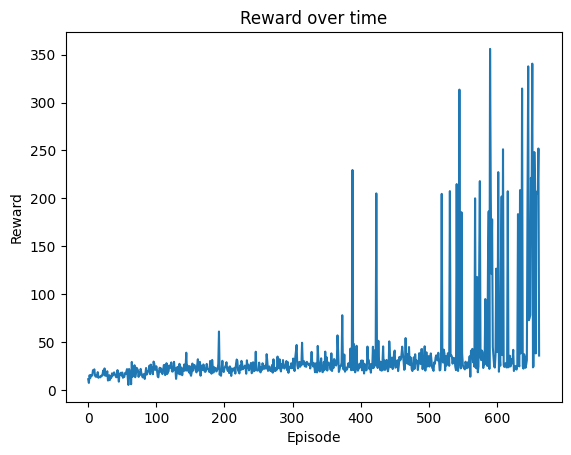

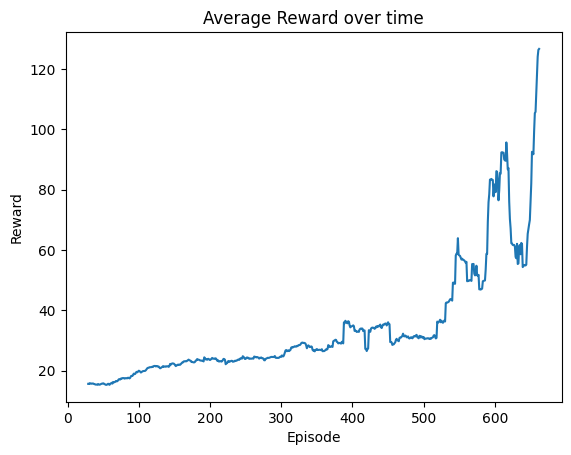

In [28]:
data = multi_agent.rewardsData

plt.plot(data)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward over time")
plt.show()

w = 30

numbers_series = pd.Series(data)
windows = numbers_series.rolling(w)
moving_averages = windows.mean()
moving_averages_list = moving_averages.tolist()

plt.plot(moving_averages_list)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average Reward over time")
plt.show()

# Saving the Model

In [138]:
directory = "Model_600"
    
# Parent Directory path 
parent_dir = "Models"
    
# Path 
path = os.path.join(parent_dir, directory) 
    
os.mkdir(path) 
print("Directory '% s' created" % directory) 
    
path = parent_dir + "/" + directory + "/"

target_model = multi_agent.target_model
target_model.save(path + "target")

model = multi_agent.model
model.save(path + "model")

memory = list(multi_agent.replay_memory)
with open(path + 'memory.txt', 'w') as f:
    for e in multi_agent.replay_memory:
        f.write(str(e) + '\n')
print("Done saving model: " + directory)

Directory 'Model_600' created
INFO:tensorflow:Assets written to: Models/Model_600/target\assets
INFO:tensorflow:Assets written to: Models/Model_600/model\assets
Done saving model: Model_600


In [139]:
def extract_memory_txt():
    with open(path + 'memory.txt') as f:
        lines = f.readlines()

    memory_data = []
    for i in range(len(lines)):

        line = lines[i][2:-2]

        data = []
        state = []
        start = 0
        for i in range(len(line)):
            if line[i] == ']':
                state.append(float(line[start:i]))
                break
            elif line[i] == ',':
                state.append(float(line[start:i]))
                start = i+1

        data.append(state)
        line = line[i+3:]
        data.append(int(line[0]))
        line = line[3:]
        for i in range(len(line)):
            if line[i] == ',':
                data.append(float(line[:i]))
                break
        line = line[i+3:]

        state = []
        start = 0
        for i in range(len(line)):
            if line[i] == ']':
                state.append(float(line[start:i]))
                break
            elif line[i] == ',':
                state.append(float(line[start:i]))
                start = i+1
        data.append(state)
        line = line[i+3:]
        if line[0] == 'F':
            data.append(False)
        else:
            data.append(True)

        memory_data.append(data)
    return memory_data

# Loading trained Model

In [142]:
# Parent Directory path 
parent_dir = "Models"

directory = "Model_600"
    
# Path 
path = parent_dir + "/" + directory + "/"

LoadedModel = keras.models.load_model(path + 'model')
LoadedTarget = keras.models.load_model(path + 'target')
LoadedMemory = extract_memory_txt()


observation_space = env.observation_space
action_space = env.action_space

print("Observation Space : " + str(observation_space))
print("Action Space : " + str(action_space))

LoadedAgent = minDQN_Agent(observation_space, action_space)
LoadedAgent.model = LoadedModel
LoadedAgent.target_model = LoadedTarget
LoadedAgent.replay_memory = deque(LoadedMemory)
LoadedAgent.setEpsilon(0.2,0.05,0.001)

Observation Space : 7
Action Space : 5


# Watch trained model results

In [143]:
print("Start of watching phase\n")
env = car_environment()

human_control = False
episode = 0
watch_episodes = 300

rewardsData = []
while episode < watch_episodes and env.run:
    state = env.reset()
    done = False
    while not done and env.run:
    
        action = LoadedAgent.getAction(state)
        next_state, reward, done = env.step(action, human_control)
        experience = state, action, reward, next_state, done
        
        if done:
            print('Episode = {}, total reward: {}, , epsilon = {}'.format(episode, round(LoadedAgent.total_training_rewards, 1), round(LoadedAgent.epsilon, 3)))
            rewardsData.append(LoadedAgent.total_training_rewards)

        LoadedAgent.train(experience)
        state = next_state
         
        if env.run is False:
            break
    episode += 1
    
print("\nEnd of watching phase\n")
env.close()


Start of watching phase

Episode = 0, total reward: 21.1, , epsilon = 0.2
Episode = 1, total reward: 254.3, , epsilon = 0.2

End of watching phase



# Human Control

In [10]:
env = car_environment()
action_space = env.action_space
observation_space = env.observation_space

print("Action Space : " + str(action_space))
print("Observation Space : " + str(observation_space))

env = car_environment()
state = env.reset()
data = []
human_control = True
while env.run:
    data.append(env.step(None, human_control))

Action Space : 5
Observation Space : 7
